In [1]:
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.table as tbl
import pymaster as nmt
import os, os.path
from astropy.io import ascii
import random
import matplotlib as mpl
from random import seed
import random
from astropy.table import QTable
import gzip
import time
from scipy.optimize import curve_fit
from astropy.table import Table

In [2]:
# Directories and KeyWords
ICDirEvents = 'IceCube_dataset10/events/' #directory containing IceCube events dataset files
ICDirIrfs = 'IceCube_dataset10/irfs/' #directory containing IceCube Effective areas and Smearing Matrix dataset files
ICKWAeff = 'Area.csv' #IceCube effective area files keyword
ICKWSmr = 'smearing.csv' #IceCube smearing files keyword

#loading in galaxy maps
GalMapDir = 'Galaxy_Maps' #directory containing galaxy maps (and mask)
GalMapKW = 'map' #galaxy map files keyword
GalMaskKW = 'mask' #galaxy mask file keyword

In [3]:
# Creating full datasets

ICEventsFilenames=sorted(os.listdir(ICDirEvents))
ICIrfsFilenames=sorted(os.listdir(ICDirIrfs))

ICEventList = []
ICAeffList = []
ICSmrList = []

for i in range(len(ICEventsFilenames)):
    ICEventData = tbl.Table.read(ICDirEvents + '/' + ICEventsFilenames[i], format = 'ascii')
    ICEventData['Year'] = np.full(len(ICEventData), i) #add column for year each neutrino event is from
    ICEventList.append(ICEventData)
ICEventFull = tbl.vstack(ICEventList)

for i in range(len(ICIrfsFilenames)):
    if ICKWAeff in str(ICIrfsFilenames[i]):
        ICAeffData = tbl.Table.read(ICDirIrfs + '/' + ICIrfsFilenames[i], format = 'ascii')
        ICAeffData['Season'] = np.full(len(ICAeffData), ICIrfsFilenames[i].replace('_effectiveArea.csv', '')) #add column for year each neutrino event is from
        ICAeffList.append(ICAeffData)
    if ICKWSmr in str(ICIrfsFilenames[i]):
        ICSmrData = tbl.Table.read(ICDirIrfs + '/' + ICIrfsFilenames[i], format = 'ascii')
        ICSmrData['Season'] = np.full(len(ICSmrData), ICIrfsFilenames[i].replace('_smearing.csv', '')) #add column for year each neutrino event is from
        ICSmrList.append(ICSmrData)
ICAeffFull = tbl.vstack(ICAeffList)
ICSmrFull = tbl.vstack(ICSmrList)

#finds filenames of all galaxy map (and mask) files, sorted alphanumerically
GalMapAllFilenames = sorted(os.listdir(GalMapDir))

#differentiates the galaxy mask file from the galaxy map files
GalMapFilenames = []
for i in GalMapAllFilenames: #only appends files to lists if chosen keywords contained in filenames
    if GalMapKW in i:
        GalMapFilenames.append(i)
    elif GalMaskKW in i: #assumes one mask for all galaxy maps
        GalMaskFilename = i

In [4]:
# parameters
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
DecMin = -5

# auxiliary quantities
AeffSeasonCol = 'Season' #name of min energy column in Aeff table
AeffEMinCol = 'log10(E_nu/GeV)_min' #name of min energy column in Aeff table
AeffEMaxCol = 'log10(E_nu/GeV)_max' #name of max energy column in Aeff table
AeffDecMinCol = 'Dec_nu_min[deg]' #name of min declination column in Aeff table
AeffDecMaxCol = 'Dec_nu_max[deg]' #name of max declination column in Aeff table
AeffCol = 'A_Eff[cm^2]' #name of Aeff column in Aeff table
AeffUnits = 0.0001 #factor to convert Aeff to m^2
YearSeason = {2008: 'IC40',
             2009: 'IC59',
             2010: 'IC79',
             2011: 'IC86_I',
             2012: 'IC86_II',
             2013: 'IC86_II',
             2014: 'IC86_II',
             2015: 'IC86_II',
             2016: 'IC86_II',
             2017: 'IC86_II',}
EbinMin = np.log10(300)
EbinMax = np.log10(300000)
Ebinning = 3
Ebinstep = (EbinMax-EbinMin)/Ebinning
nyears = 10


ICEMapBands = [(np.log10(300),np.log10(300)+1),(np.log10(300)+1,np.log10(300)+2),(np.log10(300)+2,np.log10(300)+3)]
AeffMaskFrac = 0.10 #fractional cutoff (with 1 being maximum Aeff) to mask weighted effective area maps

In [6]:
# Ben's Aeff maps
BenWeightedAeffMap = np.zeros([3, 10, NPIX])
for i in range(Ebinning):
    for j in range(nyears):
        BenWeightedAeffMap[i,j] = hp.read_map(f'WeightedAeffMaps/WeightedAeffEnergy{i}Season{j}.fits.gz')

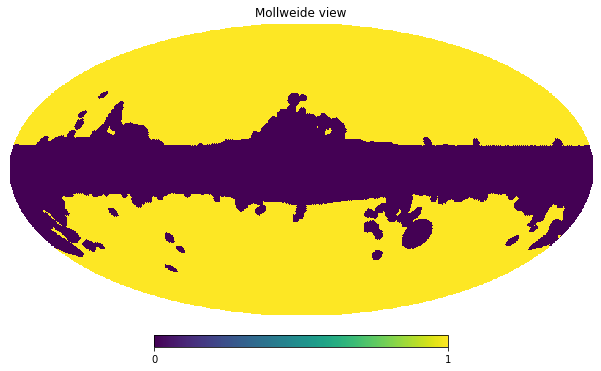

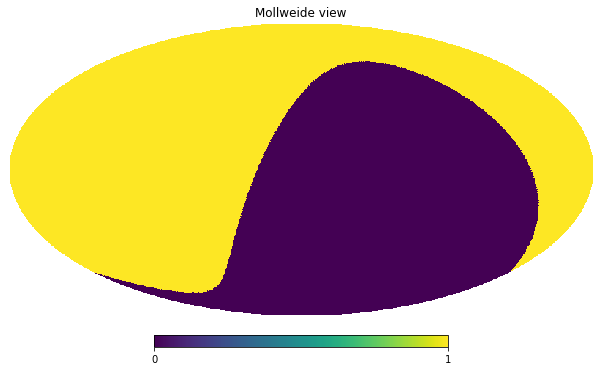

In [7]:
# 2MPZ mask
GalMaskOrigRes = hp.read_map(GalMapDir + '/' + GalMaskFilename)
GalMask = hp.ud_grade(GalMaskOrigRes, NSIDE)
GalMask[GalMask > 0.5] = 1
GalMask[GalMask <= 0.5] = 0
hp.mollview(GalMask)
# dec mask
DecMask = np.ones(NPIX)
r = hp.Rotator(coord=['G','C'])
lpix, bpix = hp.pix2ang(NSIDE, np.arange(NPIX), lonlat=True)
RApix,Decpix = r(lpix, bpix, lonlat=True)
DecMask[Decpix<=DecMin]=0
hp.mollview(DecMask)

# masks from Ben's Aeff maps
#AeffMask = np.ones(BenWeightedAeffMap.shape)
#AeffMask[BenWeightedAeffMap==0]=0

WeightedAeffMask = np.ones([Ebinning, nyears, NPIX])
#creates mask for each energy bin, season
for i in range(len(ICEMapBands)):
    for j in range(len(ICAeffList)):
        MaxWeightedAeff = np.max(BenWeightedAeffMap[i][j]) #finds max weighted effective area value
            
        #pixels are masked if lower than chosen fraction of max
        WeightedMaskIndices = np.where(BenWeightedAeffMap[i][j] <= AeffMaskFrac*MaxWeightedAeff)[0]
        WeightedAeffMask[i][j][WeightedMaskIndices] = 0
AeffMask = WeightedAeffMask

# combined mask
CombinedMask = DecMask*GalMask*AeffMask

In [8]:
def get_mask(ebin, year, Galclean=True, Decclean=True, Aeffclean=True):
    if Galclean == True:
        mask = GalMask
    else:
        mask = np.ones(NPIX)
    if Decclean == True:
        mask = mask*DecMask
    else:
        pass
    if Aeffclean == True:
        mask = mask*AeffMask[ebin, year]
    else:
        pass
    return mask

In [9]:
# declination distribution
def dec_dist(cat):
    hist = np.histogram(cat['Dec[deg]'], bins=180, range=(-90,90), density=True)
    return hist

In [10]:
# data events
def get_data_events(ebin, year):
    Emin = EbinMin+ebin
    Emax = EbinMin+Ebinstep+ebin
    cat = ICEventFull[(ICEventFull['Year']==year)&
                          (ICEventFull['log10(E/GeV)']>=Emin)&
                          (ICEventFull['log10(E/GeV)']<=Emax)]
    return cat

In [11]:
# data events outside the masked region
def get_unmasked_events(ebin, year, Galclean=True, Decclean=True, Aeffclean=True):
    # mask
    mask = get_mask(ebin, year, Galclean=Galclean, Decclean=Decclean, Aeffclean=Aeffclean)
    # catalog
    cat = get_data_events(ebin, year)
    r = hp.Rotator(coord=['C','G'])
    lpix, bpix = r(cat['RA[deg]'], cat['Dec[deg]'], lonlat=True)
    pixels = hp.ang2pix(NSIDE, lpix, bpix, lonlat=True)
    badpixels = np.ones(len(pixels))
    for i in range(len(pixels)):
        if (mask[pixels[i]]==0):
            badpixels[i] = 0
        else:
            pass
    cat_unmasked = cat[badpixels>0]
    return cat_unmasked

In [12]:
for i in range(Ebinning):
    for j in range(nyears):
        print(f'EnergyBin={i}, Year:{j}, Total={len(get_data_events(i,j))}, Unmasked={len(get_unmasked_events(i,j))}')

EnergyBin=0, Year:0, Total=9693, Unmasked=6679
EnergyBin=0, Year:1, Total=30344, Unmasked=21024
EnergyBin=0, Year:2, Total=38941, Unmasked=26099
EnergyBin=0, Year:3, Total=83420, Unmasked=56910
EnergyBin=0, Year:4, Total=77338, Unmasked=52847
EnergyBin=0, Year:5, Total=86540, Unmasked=59423
EnergyBin=0, Year:6, Total=73322, Unmasked=44575
EnergyBin=0, Year:7, Total=98905, Unmasked=67878
EnergyBin=0, Year:8, Total=84237, Unmasked=57561
EnergyBin=0, Year:9, Total=86401, Unmasked=59067
EnergyBin=1, Year:0, Total=6988, Unmasked=4467
EnergyBin=1, Year:1, Total=19407, Unmasked=11978
EnergyBin=1, Year:2, Total=24466, Unmasked=11846
EnergyBin=1, Year:3, Total=9875, Unmasked=2987
EnergyBin=1, Year:4, Total=9010, Unmasked=2748
EnergyBin=1, Year:5, Total=10137, Unmasked=3134
EnergyBin=1, Year:6, Total=26663, Unmasked=2572
EnergyBin=1, Year:7, Total=11480, Unmasked=2420
EnergyBin=1, Year:8, Total=10015, Unmasked=2977
EnergyBin=1, Year:9, Total=11449, Unmasked=2959
EnergyBin=2, Year:0, Total=6530, 

In [13]:
for i in range(Ebinning):
    sumyears=0
    sumyears_unmasked=0
    for j in range(nyears):
        sumyears = sumyears+len(get_data_events(i,j))
        sumyears_unmasked = sumyears_unmasked+len(get_unmasked_events(i,j))
    print(f'EnergyBin={i}, Total={sumyears}, Unmasked={sumyears_unmasked}')    

EnergyBin=0, Total=669141, Unmasked=452063
EnergyBin=1, Total=139490, Unmasked=48088
EnergyBin=2, Total=239853, Unmasked=1111


In [14]:
def comp_dec_hist(ebin,year):
    plt.hist(get_data_events(ebin,year)['Dec[deg]'], histtype='step', bins=80, density=True)
    plt.hist(get_unmasked_events(ebin,year)['Dec[deg]'], histtype='step', bins=80, density=True)
    return plt.show()

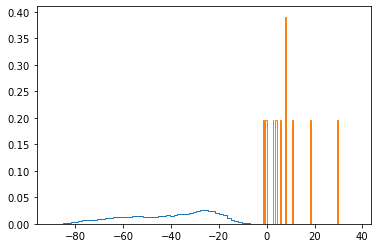

In [15]:
comp_dec_hist(2,5)

In [16]:
def get_hitmap(ebin, year, clean=True):
    if clean==True:
        cat = get_unmasked_events(ebin, year)
    else:
        cat = get_data_events(ebin, year)
    r = hp.Rotator(coord=['C','G'])
    l, b = r(cat['RA[deg]'], cat['Dec[deg]'], lonlat=True)
    pixels = hp.ang2pix(NSIDE, l, b, lonlat=True)
    hitmap = np.bincount(pixels, minlength=NPIX)
    return hitmap

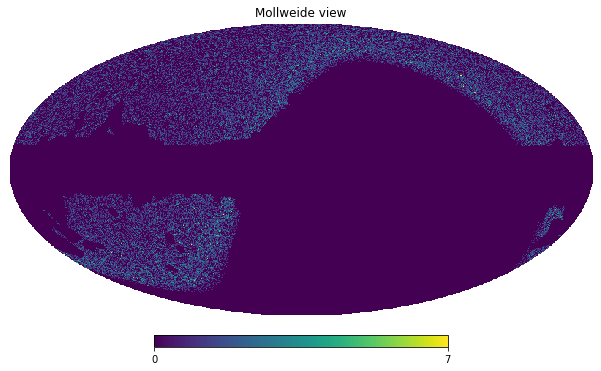

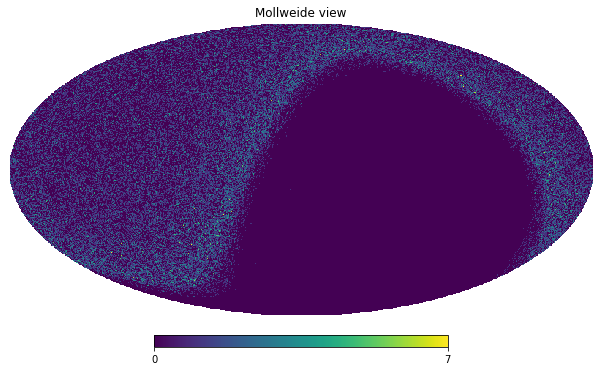

In [17]:
hp.mollview(get_hitmap(0,9))
hp.mollview(get_hitmap(0,9,clean=False))

In [18]:
# Probabilities Maps
# 2MPZ delta maps
GalMapsOrigRes = []
for i in GalMapFilenames:
    GalMapsOrigRes.append(hp.read_map(GalMapDir + '/' + i))
GalMaps = np.zeros([len(GalMapsOrigRes),NPIX])
for i in range(len(GalMapsOrigRes)):
    #changes galaxy maps NSIDE to match that of IceCube data
    GalMaps[i]= hp.ud_grade(GalMapsOrigRes[i], NSIDE)
    #sets masked pixels
    GalMaps[i][np.where(GalMask == 0)] = 0
# 2MPZ density maps = delta - min(delta)
for i in range(len(GalMapsOrigRes)):
    GalMaps[i] = GalMaps[i]-np.amin(GalMaps[i])
    GalMaps[i][np.where(GalMask == 0)] = 0
# Product with Aeff Maps
ProbMaps = np.zeros([Ebinning, nyears,len(GalMaps), NPIX])
for i in range(Ebinning):
    for j in range(nyears):
        for k in range(len(GalMaps)):
            prod = GalMaps[k]*BenWeightedAeffMap[i,j]*DecMask
            norm = np.sum(prod)
            ProbMaps[i,j,k] = prod/norm

In [19]:
def syn_atm(ebin, year, n_atm):
    cat = get_data_events(ebin, year)
    N = 3*len(cat)
    hist = dec_dist(cat)[0]*N
    bins = dec_dist(cat)[1]
    N_poisson = np.random.poisson(hist)
    DEC=[]
    for i in range(0,len(hist)):
                if hist[i]==0:
                    pass
                else:
                    for j in range(0,N_poisson[i]+1):
                        #random declination inside the bin
                        dec = bins[i]+(bins[i+1]-bins[i])*np.random.random_sample()
                        DEC.append(dec)
    DEC = np.array(DEC)
    RA = np.zeros(len(DEC))
    for i in range(len(DEC)):
        RA[i] = 360*np.random.random_sample()
        
    # atm selection
    array = np.arange(len(DEC))
    random.shuffle(array)
    
    DEC_shuffed = np.zeros(len(DEC))
    RA_shuffed = np.zeros(len(RA))
    for i in range(len(array)):
        DEC_shuffed[i] = DEC[array[i]] 
        RA_shuffed[i] = RA[array[i]] 
        
    DEC_clean = DEC_shuffed[:n_atm]
    RA_clean = RA_shuffed[:n_atm]
    
    return DEC_clean, RA_clean

In [20]:
def syn_astro(ebin, year, zbin, n_astro):
    cat = get_unmasked_events(ebin,year)
    N = 3*len(cat)
    N_map = N*ProbMaps[ebin, year, zbin]
    N_poisson = np.random.poisson(N_map)
    
    pixels = np.repeat(np.arange(len(N_poisson)), N_poisson.astype('int64'))
    l, b = hp.pix2ang(NSIDE, pixels,lonlat=True)
    r = hp.Rotator(coord=['G','C'])
    RA, DEC = r(l, b, lonlat=True)
    
    # astro selection
    array = np.arange(len(DEC))
    random.shuffle(array)
    
    DEC_shuffed = np.zeros(len(DEC))
    RA_shuffed = np.zeros(len(RA))
    for i in range(len(array)):
        DEC_shuffed[i] = DEC[array[i]] 
        RA_shuffed[i] = RA[array[i]] 
        
    DEC_clean = DEC_shuffed[:n_astro]
    RA_clean = RA_shuffed[:n_astro]
    
    return DEC_clean, RA_clean

In [21]:
def poisson_total(ebin, year, fastro):
    # full catalog
    cat = get_data_events(ebin,year)
    Ntotal = len(cat)
    Nastro = np.round(fastro*Ntotal)
    Natm = Ntotal - Nastro
    Ntotal_poisson = np.random.poisson(Ntotal)
    Nastro_poisson = np.round(fastro*Ntotal_poisson)
    Natm_poisson = Ntotal_poisson - Nastro_poisson
    
    # unmasked region
    cat_unmasked = get_unmasked_events(ebin, year)
    Ntotal_unmasked = len(cat_unmasked)
    frac = Ntotal_unmasked/Ntotal
    
    Ntotal_poisson_unmasked = frac*Ntotal_poisson
    Nastro_poisson_unmasked = np.round(fastro*Ntotal_poisson_unmasked)
    Natm_poisson_unmasked = Ntotal_poisson_unmasked - Nastro_poisson_unmasked
    
    # astro masked regions
    
    Ntotal_poisson_masked = Ntotal_poisson - Ntotal_poisson_unmasked
    Nastro_poisson_masked = np.round(fastro*Ntotal_poisson_masked)
    
    
    return Natm_poisson, Nastro_poisson_unmasked, Nastro_poisson_masked

In [22]:
def syn_cat(ebin, year, zbin, fastro):
    n_atm, n_astro, n_astro_masked = poisson_total(ebin, year, fastro)
    
    atm = syn_atm(ebin, year, int(n_atm))
    astro = syn_astro(ebin, year, zbin, int(n_astro))
    
    # excluding atm events inside the mask
    # mask
    mask = get_mask(ebin, year)
    r = hp.Rotator(coord=['C','G'])
    lpix, bpix = r(atm[1], atm[0], lonlat=True)
    pixels = hp.ang2pix(NSIDE, lpix, bpix, lonlat=True)
    badpixels = np.ones(len(pixels))
    for i in range(len(pixels)):
        if (mask[pixels[i]]==0):
            badpixels[i] = 0
        else:
            pass
    atmDEC_clean = atm[0][badpixels>0]
    atmRA_clean = atm[1][badpixels>0]
    
    
    
    DEC_atm = atmDEC_clean
    RA_atm  = atmRA_clean  
    EBIN_atm = np.full(len(DEC_atm),ebin)
    YEAR_atm = np.full(len(DEC_atm),year)
    KIND_atm = np.full(len(DEC_atm),'atm')
    
    DEC_astro = astro[0]
    RA_astro  = astro[1]  
    EBIN_astro = np.full(len(DEC_astro),ebin)
    YEAR_astro = np.full(len(DEC_astro),year)
    KIND_astro = np.full(len(DEC_astro),'astro')
    
    
    fastro_output = (len(DEC_astro))/(len(DEC_atm)+len(DEC_astro))
    
    DEC = np.append(DEC_atm, DEC_astro)
    RA  = np.append(RA_atm, RA_astro)
    EBIN = np.append(EBIN_atm, EBIN_astro)
    YEAR = np.append(YEAR_atm, YEAR_astro)
    KIND = np.append(KIND_atm, KIND_astro)
    
    
    ZBIN = np.full(len(DEC), zbin)
    FASTRO = np.full(len(DEC), fastro_output)
    
    cat = Table()
    cat['Dec[deg]'] = DEC
    cat['RA[deg]'] = RA
    cat['EnergyBin'] = EBIN
    cat['Year'] = YEAR
    cat['kind'] = KIND
    cat['zbin'] = ZBIN
    cat['fastro'] = FASTRO
    return cat

In [26]:
def hitmap(dec, ra):
    r = hp.Rotator(coord=['C','G'])
    l, b = r(ra, dec, lonlat=True)
    pixels = hp.ang2pix(NSIDE, l, b, lonlat=True)
    hitmap = np.bincount(pixels, minlength=NPIX)
    return hitmap

In [27]:
def map_comp(ebin, year, zbin, fastro):
    cat = get_unmasked_events(ebin,year)
    cat_syn = syn_cat(ebin, year, zbin, fastro)
    hitmap_cat = hitmap(cat['Dec[deg]'], cat['RA[deg]'])
    hitmap_cat_syn = hitmap(cat_syn['Dec[deg]'], cat_syn['RA[deg]'])
    return hp.mollview(hitmap_cat), hp.mollview(hitmap_cat_syn)

In [28]:
def map_comp_allyears(ebin, zbin, fastro):
    hitmap_cat = np.zeros(NPIX)
    hitmap_cat_syn = np.zeros(NPIX)
    for i in range(nyears):
        cat = get_unmasked_events(ebin,i)
        cat_syn = syn_cat(ebin, i, zbin, fastro)
        hitmap_cat = hitmap_cat + hitmap(cat['Dec[deg]'], cat['RA[deg]'])
        hitmap_cat_syn = hitmap_cat_syn + hitmap(cat_syn['Dec[deg]'], cat_syn['RA[deg]'])
    return hp.mollview(hitmap_cat), hp.mollview(hitmap_cat_syn)

(None, None)

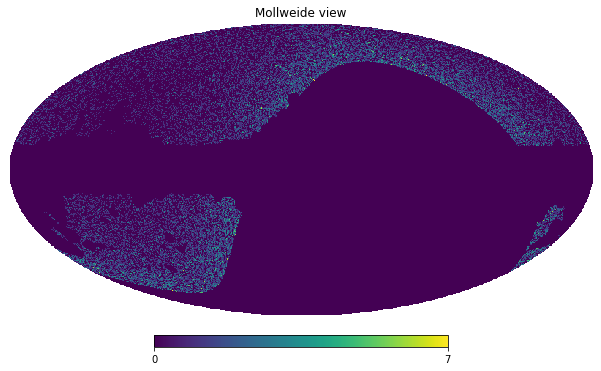

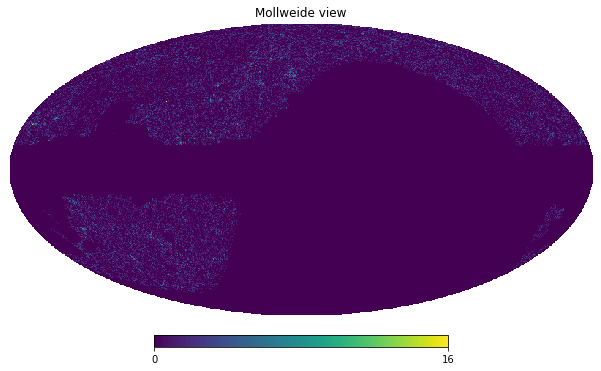

In [29]:
map_comp_allyears(1,0,1)

In [30]:
def hist_comp(ebin, year, zbin, fastro):
    cat = get_unmasked_events(ebin,year)
    cat_syn = syn_cat(ebin, year, zbin, fastro)
    plt.hist(cat['Dec[deg]'], histtype='step', density=True)
    plt.hist(cat_syn['Dec[deg]'], histtype='step', density=True)
    return plt.show()

In [31]:
def hist_comp_allyears(ebin, zbin, fastro):
    DEC = np.array([])
    DEC_syn = np.array([])
    for i in range(nyears):
        DEC = np.append(DEC, get_unmasked_events(ebin,i)['Dec[deg]'])
        DEC_syn = np.append(DEC_syn,syn_cat(ebin, i, zbin, fastro)['Dec[deg]'])
    plt.hist(DEC, histtype='step', density=True)
    plt.hist(DEC_syn, histtype='step', density=True)
    return plt.show()

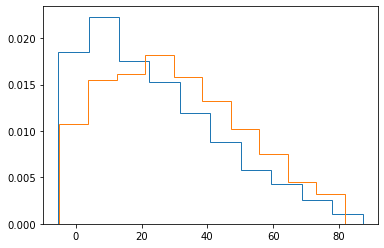

In [32]:
hist_comp_allyears(0,0,1)

In [33]:
def syn_cat_full(zbin, fastro_bin):
    syn_list = []
    for i in range(Ebinning):
        fastro = fastro_bin[i]
        for j in range(nyears):
            syn = syn_cat(i,j,zbin, fastro)
            syn_list.append(syn)
    full_cat = tbl.vstack(syn_list)
    return full_cat

In [38]:
synth_bestfit_z0 = syn_cat_full(0,[0.0022,0.012,0.15])
synth_fullastro_z0 = syn_cat_full(0,[1,1,1])

In [63]:
# Adds energy column to tables
synth_bestfit_energies = [np.mean(ICEMapBands[bin]) for bin in synth_bestfit_z0['EnergyBin']]
synth_fullastro_energies = [np.mean(ICEMapBands[bin]) for bin in synth_fullastro_z0['EnergyBin']]

synth_bestfit_z0['log10(E/GeV)'] = synth_bestfit_energies
synth_fullastro_z0['log10(E/GeV)'] = synth_fullastro_energies

In [67]:
synth_bestfit_dir = 'xCell_output/synth_bestfit/events/' # Directory for best fit events
synth_fullastro_dir = 'xCell_output/synth_fullastro/events/' # Directory for full astro events

# Separates and saves tables by years
synth_event_fnames = ['IC40', 'IC59', 'IC79', 'IC86_I', 'IC86_II', 'IC86_III', 'IC86_IV', 'IC86_V', 
                     'IC86_VI', 'IC86_VII']
for i, fname in enumerate(synth_event_fnames):
    synth_file = synth_bestfit_z0[synth_bestfit_z0['Year']==i]
    full_fname = synth_bestfit_dir + f'{fname}_exp.csv'
    ascii.write(synth_file, full_fname, overwrite=True)
    synth_file = synth_fullastro_z0[synth_fullastro_z0['Year']==i]
    full_fname = synth_fullastro_dir + f'{fname}_exp.csv'
    ascii.write(synth_file, full_fname, overwrite=True)

In [ ]:
# hdu_list = fits.HDUList([
#     fits.PrimaryHDU(),
#     fits.table_to_hdu(synthetic_bestfit_z0)
# ])
# hdu_list.writeto('synthetic_data/synthetic_bestfit_z0.fits')

In [ ]:
# hdu_list = fits.HDUList([
#     fits.PrimaryHDU(),
#     fits.table_to_hdu(synthetic_fullastro_z0)
# ])
# hdu_list.writeto('synthetic_data/synthetic_fullastro_z0.fits')

# Trash

In [ ]:
def syn_astro_masked(ebin, year, zbin, n_astro_masked):
    mask = get_mask(ebin, year)
    maskProbMaps = np.ones(NPIX)
    maskProbMaps[mask==1]=0
    AeffMap = BenWeightedAeffMap[ebin,year]
    
    maskProbMaps = maskProbMaps*AeffMap/np.sum(maskProbMaps*AeffMap)
 
    cat = get_data_events(ebin,year)
    cat_clean = get_unmasked_events(ebin, year)
    
    N = 3*(len(cat)-len(cat_clean))
    
    N_map = N*maskProbMaps
    N_poisson = np.random.poisson(N_map)
    
    pixels = np.repeat(np.arange(len(N_poisson)), N_poisson.astype('int64'))
    l, b = hp.pix2ang(NSIDE, pixels,lonlat=True)
    r = hp.Rotator(coord=['G','C'])
    RA, DEC = r(l, b, lonlat=True)
    
    # astro selection
    array = np.arange(len(DEC))
    random.shuffle(array)
    
    DEC_shuffed = np.zeros(len(DEC))
    RA_shuffed = np.zeros(len(RA))
    for i in range(len(array)):
        DEC_shuffed[i] = DEC[array[i]] 
        RA_shuffed[i] = RA[array[i]] 

    DEC_clean = DEC_shuffed[:n_astro_masked]
    RA_clean = RA_shuffed[:n_astro_masked]

    return DEC_clean, RA_clean

In [ ]:
def syn_cat(ebin, year, zbin, fastro):
    n_atm, n_astro, n_astro_masked = poisson_total(ebin, year, fastro)
    
    atm = syn_atm(ebin, year, int(n_atm))
    astro = syn_astro(ebin, year, zbin, int(n_astro))
    astro_masked = syn_astro_masked(ebin, year, zbin, int(n_astro_masked))
    
    DEC_atm = atm[0]
    RA_atm  = atm[1]  
    EBIN_atm = np.full(len(DEC_atm),ebin)
    YEAR_atm = np.full(len(DEC_atm),year)
    KIND_atm = np.full(len(DEC_atm),'atm')
    
    DEC_astro = astro[0]
    RA_astro  = astro[1]  
    EBIN_astro = np.full(len(DEC_astro),ebin)
    YEAR_astro = np.full(len(DEC_astro),year)
    KIND_astro = np.full(len(DEC_astro),'astro')
    
    DEC_astro_masked = astro_masked[0]
    RA_astro_masked  = astro_masked[1]  
    EBIN_astro_masked = np.full(len(DEC_astro_masked),ebin)
    YEAR_astro_masked = np.full(len(DEC_astro_masked),year)
    KIND_astro_masked = np.full(len(DEC_astro_masked),'astro')
    
    fastro_output = (len(DEC_astro)+len(DEC_astro_masked))/(len(DEC_atm)+len(DEC_astro)+len(DEC_astro_masked))
    
    DEC = np.append(DEC_atm, DEC_astro)
    RA  = np.append(RA_atm, RA_astro)
    EBIN = np.append(EBIN_atm, EBIN_astro)
    YEAR = np.append(YEAR_atm, YEAR_astro)
    KIND = np.append(KIND_atm, KIND_astro)
    
    DEC = np.append(DEC, DEC_astro_masked)
    RA  = np.append(RA, RA_astro_masked)
    EBIN = np.append(EBIN, EBIN_astro_masked)
    YEAR = np.append(YEAR, YEAR_astro_masked)
    KIND = np.append(KIND, KIND_astro_masked)
    
    ZBIN = np.full(len(DEC), zbin)
    FASTRO = np.full(len(DEC), fastro_output)
    
    cat = Table()
    cat['Dec[deg]'] = DEC
    cat['RA[deg]'] = RA
    cat['EnergyBin'] = EBIN
    cat['Year'] = YEAR
    cat['kind'] = KIND
    cat['zbin'] = ZBIN
    cat['fastro'] = FASTRO
    return cat